# 05 StratifiedKFold: Pattern1 vs Pattern2(Adversarial Validation)

`00_prepare_data.ipynb` で作成した Titanic の Train/Test を使い、
- Pattern1: 特徴量をそのまま使う StratifiedKFold
- Pattern2: 各foldのTrain/Validで Adversarial Validation を行い、乖離特徴量を削除して StratifiedKFold
を比較します。

In [61]:
import os
import random
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, f1_score, log_loss, roc_auc_score, roc_curve

SEED = 42
N_SPLITS = 5
ADV_AUC_THRESHOLD = 0.70
ADV_DROP_TOP_K = 20

NOISE_STD_RATIO = 0.01
NOISE_SEED_OFFSET = 10_000

os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)

In [62]:
train_df = pd.read_csv('data/processed/classification_train.csv')
test_df = pd.read_csv('data/processed/classification_test.csv')

X_train_full = train_df.drop(columns=['target'])
y_train_full = train_df['target'].astype(int)
X_test = test_df.drop(columns=['target'])
y_test = test_df['target'].astype(int)

class_labels = np.sort(y_train_full.unique())
num_class = len(class_labels)

numeric_cols = X_train_full.select_dtypes(include=[np.number]).columns.tolist()
if len(numeric_cols) == 0:
    raise ValueError('数値特徴量が見つからないためノイズ注入対象を決められません。')

NOISE_TARGET_FEATURE = numeric_cols[0]
noise_base_std = float(X_train_full[NOISE_TARGET_FEATURE].std())
if np.isnan(noise_base_std) or noise_base_std == 0.0:
    noise_base_std = 1.0
NOISE_STD = noise_base_std * NOISE_STD_RATIO

print(f'Train full shape: {X_train_full.shape}')
print(f'Test shape      : {X_test.shape}')
print('Train class ratio:', y_train_full.value_counts(normalize=True).sort_index().to_dict())
print('Test  class ratio:', y_test.value_counts(normalize=True).sort_index().to_dict())
print(f'Noise feature   : {NOISE_TARGET_FEATURE}')
print(f'Noise std       : {NOISE_STD:.6f} (train std x {NOISE_STD_RATIO})')

Train full shape: (19536, 14)
Test shape      : (29306, 14)
Train class ratio: {0: 0.7366400491400491, 1: 0.26335995085995084}
Test  class ratio: {0: 0.7366068381901317, 1: 0.26339316180986827}
Noise feature   : age
Noise std       : 0.158390 (train std x 0.01)


In [63]:
def build_multiclass_model(seed):
    return lgb.LGBMClassifier(
        objective='multiclass',
        num_class=num_class,
        n_estimators=120,
        learning_rate=0.05,
        num_leaves=7,
        min_child_samples=20,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        random_state=seed,
        bagging_seed=seed,
        feature_fraction_seed=seed,
        data_random_seed=seed,
        deterministic=True,
        force_col_wise=True
    )

def evaluate_split(split_name, y_true, pred, proba):
    return {
        'Split': split_name,
        'Accuracy': accuracy_score(y_true, pred),
        'F1_macro': f1_score(y_true, pred, average='macro'),
        'LogLoss': log_loss(y_true, proba, labels=class_labels)
    }

def add_distribution_shift_noise(X_valid, X_test, feature_name, noise_std, seed):
    X_valid_noised = X_valid.copy()
    X_test_noised = X_test.copy()

    if feature_name not in X_valid_noised.columns or feature_name not in X_test_noised.columns:
        return X_valid_noised, X_test_noised

    rng_valid = np.random.default_rng(seed)
    rng_test = np.random.default_rng(seed)

    X_valid_noised.loc[:, feature_name] = (
        X_valid_noised[feature_name].to_numpy() + rng_valid.normal(0.0, noise_std, len(X_valid_noised))
    )
    X_test_noised.loc[:, feature_name] = (
        X_test_noised[feature_name].to_numpy() + rng_test.normal(0.0, noise_std, len(X_test_noised))
    )
    return X_valid_noised, X_test_noised

def plot_roc_feat(y_true, y_pred, est, cols, title_prefix='Adversarial Validation', x_max=1.0):
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred)
    ax[0].plot(fpr, tpr, label=f'AUC={auc:.3f}', marker='o', markersize=1)
    ax[0].legend()
    ax[0].grid()
    ax[0].plot(np.linspace(0, 1, 20), np.linspace(0, 1, 20), linestyle='--')
    ax[0].set_title(f'{title_prefix}: ROC curve')
    ax[0].set_xlabel('False Positive Rate')
    ax[0].set_xlim([-0.01, x_max])
    ax[0].set_ylabel('True Positive Rate')

    importance = pd.DataFrame({
        'feature': cols,
        'score': est.feature_importances_
    }).sort_values('score', ascending=False)

    top20 = importance.head(20).iloc[::-1]
    ax[1].barh(top20['feature'], top20['score'])
    ax[1].set_title(f'{title_prefix}: Top 20 Feature Importances')
    plt.tight_layout()
    plt.show()

    return auc, importance

def adversarial_drift_features(X_train_fold, X_valid_fold, auc_threshold=ADV_AUC_THRESHOLD, top_k=ADV_DROP_TOP_K, draw_plot=False):
    adv_train = X_train_fold.copy()
    adv_valid = X_valid_fold.copy()
    adv_train['dataset_label'] = 0
    adv_valid['dataset_label'] = 1
    adv_master = pd.concat([adv_train, adv_valid], axis=0)

    adv_X = adv_master.drop(columns=['dataset_label'])
    adv_y = adv_master['dataset_label']

    adv_X_train, adv_X_test, adv_y_train, adv_y_test = train_test_split(
        adv_X, adv_y,
        test_size=0.4,
        stratify=adv_y,
        random_state=SEED
    )

    adv_model = lgb.LGBMClassifier(
        objective='binary',
        n_estimators=300,
        learning_rate=0.05,
        num_leaves=31,
        random_state=SEED,
        deterministic=True,
        force_col_wise=True
    )
    adv_model.fit(adv_X_train, adv_y_train)

    adv_pred = adv_model.predict_proba(adv_X_test)[:, 1]
    adv_auc = roc_auc_score(adv_y_test, adv_pred)

    importance = pd.DataFrame({
        'feature': adv_X.columns,
        'score': adv_model.feature_importances_
    }).sort_values('score', ascending=False)

    if draw_plot:
        _ = plot_roc_feat(adv_y_test, adv_pred, adv_model, adv_X.columns, title_prefix='Adversarial Validation')

    drift_features = []
    if adv_auc >= auc_threshold:
        drift_features = importance[importance['score'] > 0]['feature'].head(top_k).tolist()

    return adv_auc, drift_features

In [64]:
def run_stratified_kfold_pattern(method_name, use_adversarial_drop=False):
    skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)
    fold_rows = []
    test_proba_folds = []
    dropped_feature_records = []

    for fold, (tr_idx, va_idx) in enumerate(skf.split(X_train_full, y_train_full), start=1):
        X_tr = X_train_full.iloc[tr_idx].copy()
        y_tr = y_train_full.iloc[tr_idx].copy()
        X_va = X_train_full.iloc[va_idx].copy()
        y_va = y_train_full.iloc[va_idx].copy()
        X_te = X_test.copy()

        X_va, X_te = add_distribution_shift_noise(
            X_valid=X_va,
            X_test=X_te,
            feature_name=NOISE_TARGET_FEATURE,
            noise_std=NOISE_STD,
            seed=SEED + NOISE_SEED_OFFSET + fold
        )

        feature_mean_by_split = {
            'Train': float(X_tr[NOISE_TARGET_FEATURE].mean()),
            'Valid': float(X_va[NOISE_TARGET_FEATURE].mean()),
            'Test': float(X_te[NOISE_TARGET_FEATURE].mean())
        }
        feature_std_by_split = {
            'Train': float(X_tr[NOISE_TARGET_FEATURE].std()),
            'Valid': float(X_va[NOISE_TARGET_FEATURE].std()),
            'Test': float(X_te[NOISE_TARGET_FEATURE].std())
        }

        adv_auc = np.nan
        dropped_features = []

        if use_adversarial_drop:
            adv_auc, dropped_features = adversarial_drift_features(X_tr, X_va, draw_plot=(fold == 1))
            max_drop = max(0, X_tr.shape[1] - 1)
            dropped_features = dropped_features[:max_drop]

            if len(dropped_features) > 0:
                X_tr = X_tr.drop(columns=dropped_features, errors='ignore')
                X_va = X_va.drop(columns=dropped_features, errors='ignore')
                X_te = X_te.drop(columns=dropped_features, errors='ignore')

        model = build_multiclass_model(SEED + fold)
        model.fit(
            X_tr, y_tr,
            eval_set=[(X_va, y_va)],
            eval_metric='multi_logloss'
        )

        tr_proba = model.predict_proba(X_tr)
        tr_pred = model.predict(X_tr)
        va_proba = model.predict_proba(X_va)
        va_pred = model.predict(X_va)
        te_proba = model.predict_proba(X_te)
        te_pred = np.argmax(te_proba, axis=1)

        test_proba_folds.append(te_proba)

        for metrics in [
            evaluate_split('Train', y_tr, tr_pred, tr_proba),
            evaluate_split('Valid', y_va, va_pred, va_proba),
            evaluate_split('Test', y_test, te_pred, te_proba)
        ]:
            row = {
                'Method': method_name,
                'Fold': fold,
                'Split': metrics['Split'],
                'Accuracy': metrics['Accuracy'],
                'F1_macro': metrics['F1_macro'],
                'LogLoss': metrics['LogLoss'],
                'AdvAUC': adv_auc,
                'DroppedFeatureCount': len(dropped_features),
                'NoiseFeature': NOISE_TARGET_FEATURE,
                'NoiseStd': NOISE_STD,
                'NoiseFeatureMean': feature_mean_by_split[metrics['Split']],
                'NoiseFeatureStd': feature_std_by_split[metrics['Split']]
            }
            fold_rows.append(row)

        dropped_feature_records.append({
            'Method': method_name,
            'Fold': fold,
            'AdvAUC': adv_auc,
            'DroppedFeatureCount': len(dropped_features),
            'DroppedFeatures': dropped_features
        })

    fold_df = pd.DataFrame(fold_rows)
    mean_df = fold_df.groupby(['Method', 'Split'], as_index=False)[['Accuracy', 'F1_macro', 'LogLoss']].mean()

    test_proba_mean = np.mean(np.stack(test_proba_folds, axis=0), axis=0)
    test_pred_mean = np.argmax(test_proba_mean, axis=1)

    drop_info_df = pd.DataFrame(dropped_feature_records)
    return fold_df, mean_df, test_pred_mean, test_proba_mean, drop_info_df

[LightGBM] [Info] Total Bins 839
[LightGBM] [Info] Number of data points in the train set: 15628, number of used features: 14
[LightGBM] [Info] Start training from score -0.305674
[LightGBM] [Info] Start training from score -1.334182
[LightGBM] [Info] Total Bins 842
[LightGBM] [Info] Number of data points in the train set: 15629, number of used features: 14
[LightGBM] [Info] Start training from score -0.305651
[LightGBM] [Info] Start training from score -1.334246
[LightGBM] [Info] Total Bins 846
[LightGBM] [Info] Number of data points in the train set: 15629, number of used features: 14
[LightGBM] [Info] Start training from score -0.305651
[LightGBM] [Info] Start training from score -1.334246
[LightGBM] [Info] Total Bins 843
[LightGBM] [Info] Number of data points in the train set: 15629, number of used features: 14
[LightGBM] [Info] Start training from score -0.305651
[LightGBM] [Info] Start training from score -1.334246
[LightGBM] [Info] Total Bins 841
[LightGBM] [Info] Number of dat

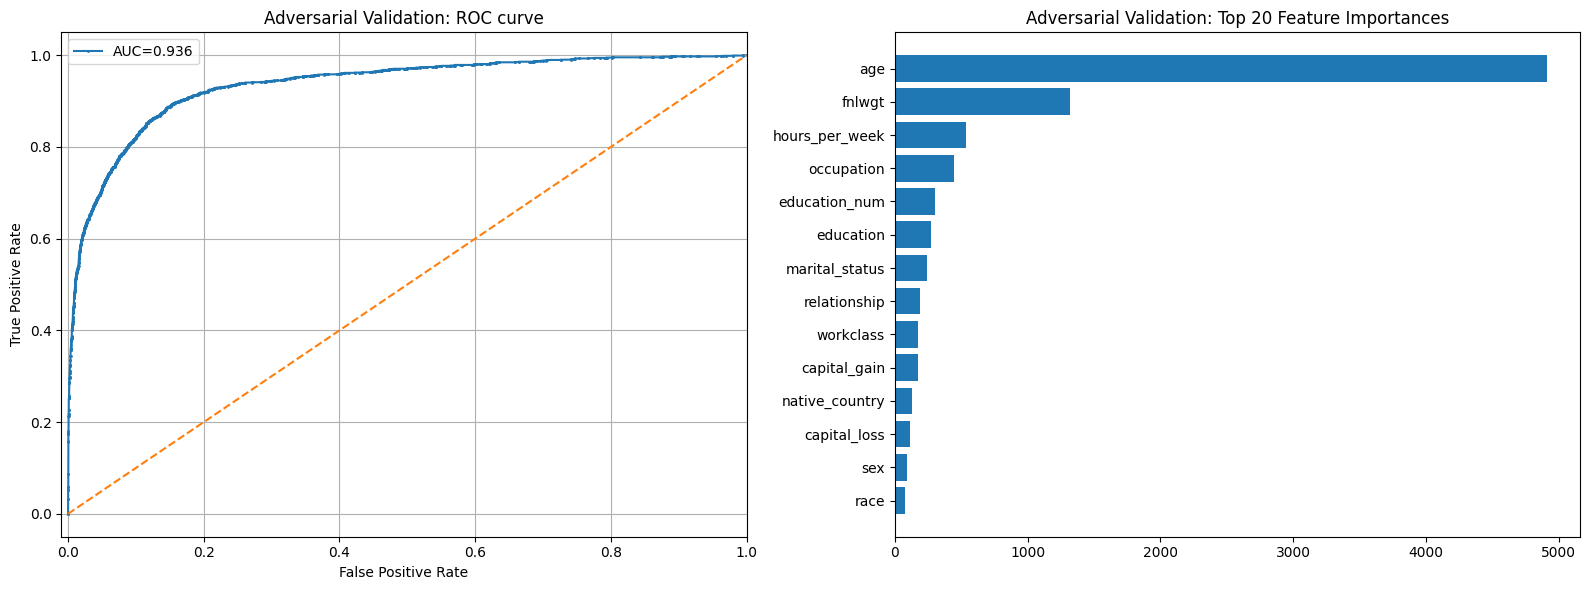

[LightGBM] [Info] Total Bins 5
[LightGBM] [Info] Number of data points in the train set: 15628, number of used features: 1
[LightGBM] [Info] Start training from score -0.305674
[LightGBM] [Info] Start training from score -1.334182
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

,Method,Fold,Split,Accuracy,F1_macro,LogLoss,AdvAUC,DroppedFeatureCount,NoiseFeature,NoiseStd,NoiseFeatureMean,NoiseFeatureStd
0,Pattern1(StratifiedKFold),1,Train,0.827425,0.747008,0.370643,NaN,0,age,0.15839,41.785892,15.855491
1,Pattern1(StratifiedKFold),1,Valid,0.821904,0.741449,0.373526,NaN,0,age,0.15839,42.039022,15.775953
2,Pattern1(StratifiedKFold),1,Test,0.826315,0.746615,0.378388,NaN,0,age,0.15839,41.734168,15.743120
3,Pattern1(StratifiedKFold),2,Train,0.829804,0.753817,0.367738,NaN,0,age,0.15839,41.870343,15.872821
4,Pattern1(StratifiedKFold),2,Valid,0.817251,0.734303,0.387688,NaN,0,age,0.15839,41.699207,15.703003


,Method,Fold,Split,Accuracy,F1_macro,LogLoss,AdvAUC,DroppedFeatureCount,NoiseFeature,NoiseStd,NoiseFeatureMean,NoiseFeatureStd
0,Pattern2(StratifiedKFold+AdversarialDrop),1,Train,0.736627,0.424171,0.572288,0.935714,13,age,0.15839,41.785892,15.855491
1,Pattern2(StratifiedKFold+AdversarialDrop),1,Valid,0.736694,0.424193,0.569798,0.935714,13,age,0.15839,42.039022,15.775953
2,Pattern2(StratifiedKFold+AdversarialDrop),1,Test,0.736607,0.424164,0.572797,0.935714,13,age,0.15839,41.734168,15.743120
3,Pattern2(StratifiedKFold+AdversarialDrop),2,Train,0.736643,0.424177,0.571645,0.935227,13,age,0.15839,41.870343,15.872821
4,Pattern2(StratifiedKFold+AdversarialDrop),2,Valid,0.736627,0.424171,0.572345,0.935227,13,age,0.15839,41.699207,15.703003


In [65]:
pattern1_fold_df, pattern1_mean_df, pattern1_test_pred, pattern1_test_proba, pattern1_drop_info = run_stratified_kfold_pattern(
    method_name='Pattern1(StratifiedKFold)',
    use_adversarial_drop=False
)

pattern2_fold_df, pattern2_mean_df, pattern2_test_pred, pattern2_test_proba, pattern2_drop_info = run_stratified_kfold_pattern(
    method_name='Pattern2(StratifiedKFold+AdversarialDrop)',
    use_adversarial_drop=True
)

display(pattern1_fold_df.head())
display(pattern2_fold_df.head())

In [66]:
comparison_df = pd.concat([pattern1_mean_df, pattern2_mean_df], ignore_index=True)
comparison_df['Split'] = pd.Categorical(comparison_df['Split'], categories=['Train', 'Valid', 'Test'], ordered=True)
comparison_df = comparison_df.sort_values(['Split', 'Method']).reset_index(drop=True)
display(comparison_df)

pivot_acc = comparison_df.pivot(index='Split', columns='Method', values='Accuracy')
pivot_f1 = comparison_df.pivot(index='Split', columns='Method', values='F1_macro')
pivot_logloss = comparison_df.pivot(index='Split', columns='Method', values='LogLoss')

diff = pd.DataFrame({
    'Accuracy diff (Pattern2 - Pattern1)': pivot_acc['Pattern2(StratifiedKFold+AdversarialDrop)'] - pivot_acc['Pattern1(StratifiedKFold)'],
    'F1 diff (Pattern2 - Pattern1)': pivot_f1['Pattern2(StratifiedKFold+AdversarialDrop)'] - pivot_f1['Pattern1(StratifiedKFold)'],
    'LogLoss diff (Pattern2 - Pattern1)': pivot_logloss['Pattern2(StratifiedKFold+AdversarialDrop)'] - pivot_logloss['Pattern1(StratifiedKFold)']
}).reset_index()
print('Difference by split (Pattern2 - Pattern1)')
display(diff)

print(f'Injected noise feature: {NOISE_TARGET_FEATURE}, noise std: {NOISE_STD:.6f}')
noise_view = pd.concat([pattern1_fold_df, pattern2_fold_df], ignore_index=True)
noise_summary = noise_view.groupby(['Method', 'Split'], as_index=False)[['NoiseFeatureMean', 'NoiseFeatureStd']].mean()
noise_summary['Split'] = pd.Categorical(noise_summary['Split'], categories=['Train', 'Valid', 'Test'], ordered=True)
noise_summary = noise_summary.sort_values(['Split', 'Method']).reset_index(drop=True)
print('Noise feature distribution summary (mean/std)')
display(noise_summary)

drop_summary = pattern2_drop_info[['Fold', 'AdvAUC', 'DroppedFeatureCount', 'DroppedFeatures']].copy()
print('Pattern2 adversarial validation summary')
display(drop_summary)

,Method,Split,Accuracy,F1_macro,LogLoss
0,Pattern1(StratifiedKFold),Train,0.827728,0.748946,0.370002
1,Pattern2(StratifiedKFold+AdversarialDrop),Train,0.744177,0.455819,0.563251
2,Pattern1(StratifiedKFold),Valid,0.824683,0.744656,0.377105
3,Pattern2(StratifiedKFold+AdversarialDrop),Valid,0.744575,0.456681,0.563588
4,Pattern1(StratifiedKFold),Test,0.826507,0.748210,0.378608
5,Pattern2(StratifiedKFold+AdversarialDrop),Test,0.743909,0.455467,0.564704


Difference by split (Pattern2 - Pattern1)


,Split,Accuracy diff (Pattern2 - Pattern1),F1 diff (Pattern2 - Pattern1),LogLoss diff (Pattern2 - Pattern1)
0,Train,-0.083551,-0.293126,0.193249
1,Valid,-0.080108,-0.287975,0.186483
2,Test,-0.082597,-0.292743,0.186097


Injected noise feature: age, noise std: 0.158390
Noise feature distribution summary (mean/std)


,Method,Split,NoiseFeatureMean,NoiseFeatureStd
0,Pattern1(StratifiedKFold),Train,41.836612,15.838985
1,Pattern2(StratifiedKFold+AdversarialDrop),Train,41.836612,15.838985
2,Pattern1(StratifiedKFold),Valid,41.835578,15.838370
3,Pattern2(StratifiedKFold+AdversarialDrop),Valid,41.835578,15.838370
4,Pattern1(StratifiedKFold),Test,41.734476,15.743699
5,Pattern2(StratifiedKFold+AdversarialDrop),Test,41.734476,15.743699


Pattern2 adversarial validation summary


,Fold,AdvAUC,DroppedFeatureCount,DroppedFeatures
0,1,0.935714,13,"[age, fnlwgt, hours_per_week, occupation, educ..."
1,2,0.935227,13,"[age, fnlwgt, hours_per_week, occupation, educ..."
2,3,0.931761,13,"[age, fnlwgt, hours_per_week, occupation, educ..."
3,4,0.940975,13,"[age, fnlwgt, hours_per_week, occupation, educ..."
4,5,0.941675,13,"[age, fnlwgt, hours_per_week, occupation, educ..."


Test prediction agreement (Pattern1 vs Pattern2): 0.8394


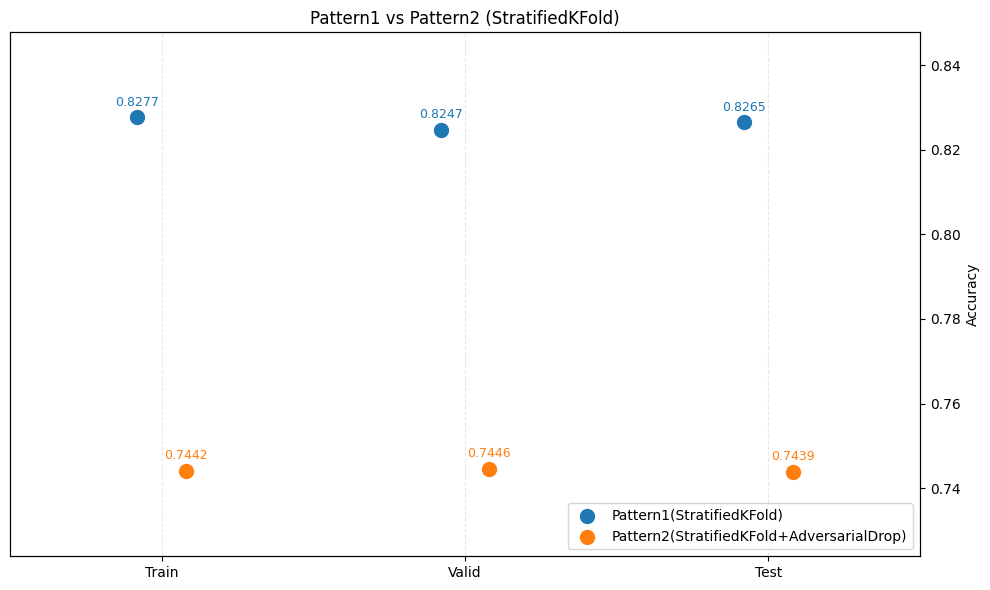

In [67]:
agreement = (pattern1_test_pred == pattern2_test_pred).mean()
print(f'Test prediction agreement (Pattern1 vs Pattern2): {agreement:.4f}')

split_order = ['Train', 'Valid', 'Test']
x = np.arange(len(split_order))
offset = 0.08

acc_p1 = [pivot_acc.loc[s, 'Pattern1(StratifiedKFold)'] for s in split_order]
acc_p2 = [pivot_acc.loc[s, 'Pattern2(StratifiedKFold+AdversarialDrop)'] for s in split_order]

fig, ax = plt.subplots(figsize=(10, 6))
ax_right = ax.twinx()

ax.set_xlim(-0.5, len(split_order) - 0.5)
ax.set_xticks(x)
ax.set_xticklabels(split_order)
ax.set_yticks([])
ax.set_ylabel('')
ax.grid(axis='x', linestyle='--', alpha=0.3)

ax_right.scatter(x - offset, acc_p1, s=100, label='Pattern1(StratifiedKFold)', color='tab:blue')
ax_right.scatter(x + offset, acc_p2, s=100, label='Pattern2(StratifiedKFold+AdversarialDrop)', color='tab:orange')

for i, score in enumerate(acc_p1):
    ax_right.text(x[i] - offset, score + 0.002, f'{score:.4f}', ha='center', va='bottom', fontsize=9, color='tab:blue')
for i, score in enumerate(acc_p2):
    ax_right.text(x[i] + offset, score + 0.002, f'{score:.4f}', ha='center', va='bottom', fontsize=9, color='tab:orange')

all_acc = np.array(acc_p1 + acc_p2)
ax_right.set_ylabel('Accuracy')
ax_right.set_ylim(max(0.0, all_acc.min() - 0.02), min(1.0, all_acc.max() + 0.02))
ax_right.legend(loc='lower right')

plt.title('Pattern1 vs Pattern2 (StratifiedKFold)')
plt.tight_layout()
plt.show()